### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from jaxflows.flows import NeuralSplineFlow
from jaxflows.train_utils import train_flow
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as onp
from jax import random
from rnpe.denoise import horseshoe_denoiser_model
from numpyro.infer import MCMC, NUTS
import jax
import seaborn as sns
from rnpe.plot_utils import pairplot


### Simulate

In [13]:
key = random.PRNGKey(0)
key, theta_key, sim_key = random.split(key, 3)
x_dim = 100
n_sim = 10000

# As described in https://arxiv.org/pdf/1708.01974.pdf
theta = random.normal(theta_key, (n_sim, 1))*25
x = random.normal(sim_key, (n_sim, x_dim)) + theta
x_misspecified = x*2  + theta # std 2 rather than 1

# Compute summary statistics
s = jnp.column_stack((x.mean(axis=1), x.std(axis=1)))
s_misspecified = jnp.column_stack((x_misspecified.mean(axis=1), x_misspecified.std(axis=1)))

# # Scale variables (based on simulations only)
s_mean, s_std = s.mean(axis=0), s.std(axis=0)
s = (s-s_mean)/s_std

s_misspecified = (s_misspecified-s_mean)/s_std

theta_mean, theta_std = theta.mean(axis=0), theta.std(axis=0)
theta = (theta-theta_mean)/theta_std

s_obs = s_misspecified[0]

### Train marginal likelihood flow

In [14]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
flow = NeuralSplineFlow(flow_key, target_dim=s.shape[1])
flow, losses = train_flow(train_key, flow, s, max_epochs=30)

 33%|███▎      | 10/30 [00:31<01:02,  3.12s/it, train=2.85, val=2.84]

Max patience reached.


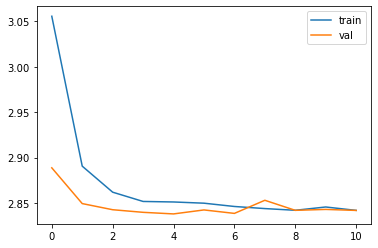

In [15]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Denoise with MCMC

In [25]:
from numpyro.infer import NUTS
from rnpe.denoise import horseshoe_denoiser_model

kernel = NUTS(horseshoe_denoiser_model, target_accept_prob=0.99) # Smaller step because of peaky distribution
mcmc = MCMC(kernel, num_warmup=5000, num_samples=10000)
key, mcmc_key = random.split(key)
mcmc.run(mcmc_key, s_obs, flow.bijection.inverse, tau_prior_scale=0.1, min_scale=0.02)  # min scale improves mixing at cost of reducing shrinkage. Target prob 0.999 and min_scale=0.005 works well. As does Target prob 0.99 and min_scale=0.02 works well.
mcmc.print_summary()


sample: 100%|██████████| 15000/15000 [00:28<00:00, 526.46it/s, 31 steps of size 3.68e-02. acc. prob=0.98]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]      1.65      3.99      0.74      0.00      3.42   4295.73      1.00
lambdas[1]     97.45    683.82     25.81      0.14    194.65   5281.59      1.00
       tau      2.32      6.21      0.67      0.00      5.42   4281.35      1.00
      z[0]      0.83      0.81      1.04     -0.62      1.83   2260.88      1.00
      z[1]     -0.10      1.01     -0.15     -1.73      1.56   4118.17      1.00

Number of divergences: 0


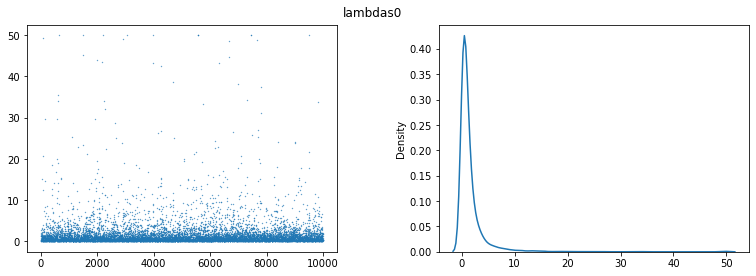

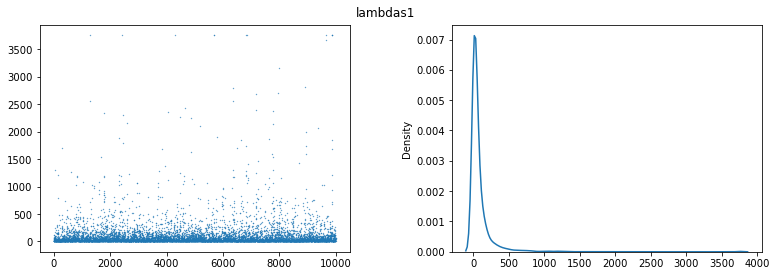

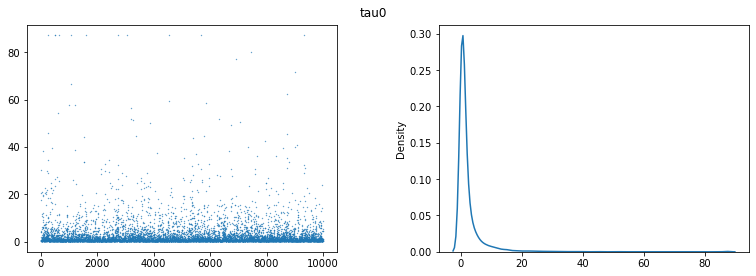

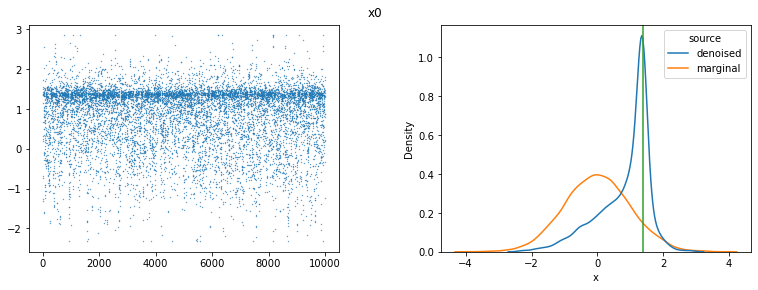

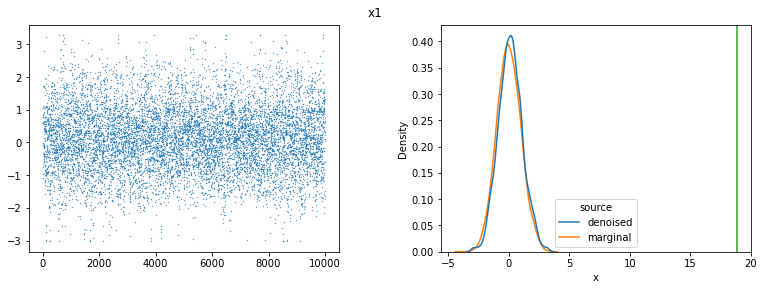

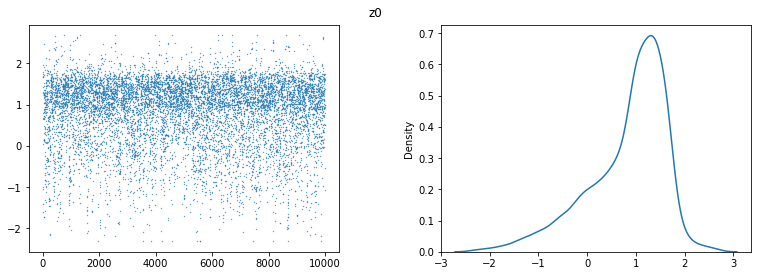

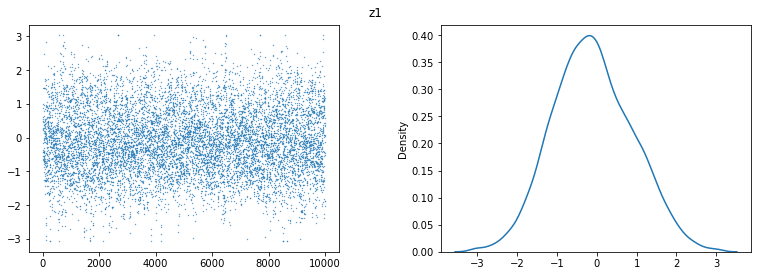

In [26]:
import pandas as pd

for sample_name, sample in mcmc.get_samples().items():
    sample = onp.array(sample)
    if sample.ndim == 1:
        sample = onp.expand_dims(sample, axis=1)  # to avoid iterating over items
    for i, col in enumerate(onp.transpose(sample)):
        col = onp.clip(col, jnp.quantile(col, 0.001), jnp.quantile(col, 0.999))
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.tight_layout(pad=2.0)
        fig.set_size_inches(12, 4)
        fig.suptitle(sample_name + str(i))
        ax1.scatter(range(len(col)), col, s=0.1)

        if sample_name == "x":
            # Plot p(s) too
            df = pd.DataFrame({
                "x": onp.concatenate((col, s[:, i])),
                "source": onp.repeat(["denoised", "marginal"], [len(col), len(s[:, i])])
            })

            sns.kdeplot(data=df, x="x", hue="source", ax=ax2, common_norm=False)
            ax2.axvline(s_obs[i].item(), color="tab:green")

        else:
            sns.kdeplot(col)
        plt.show()



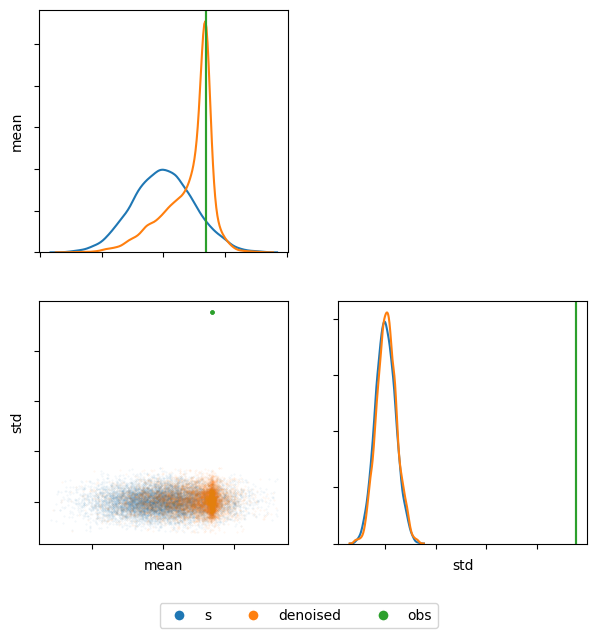

In [27]:

s_names = ["mean", "std"]
denoised = mcmc.get_samples()["x"]
pairplot((s, denoised), s_obs, col_names=s_names, names=["s", "denoised", "obs"])

### Posterior inference

In [28]:
key, flow_key, train_key = random.split(key, 3)

posterior_flow = NeuralSplineFlow(
    flow_key,
    target_dim=theta.shape[1],
    condition_dim=s.shape[1])

posterior_flow, losses = train_flow(train_key, posterior_flow, theta, s, max_epochs=30)


100%|██████████| 30/30 [00:17<00:00,  1.74it/s, train=-3.49, val=-3.6] 


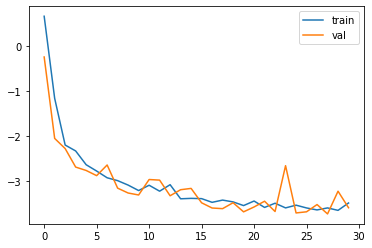

In [29]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Sample non-robust and robust posterior

In [15]:
robust_condition = mcmc.get_samples()["x"]
n_samples = robust_condition.shape[0]
non_robust_condition = jnp.repeat(jnp.expand_dims(s_obs, 0), n_samples, axis=0)
well_specified_condition = jnp.repeat(jnp.expand_dims(s_obs, 0), n_samples, axis=0)


In [16]:
keys = random.split(key, 4)
key, sample_keys = keys[0], keys[1:]

conditions = {
    "robust": robust_condition,
    "non_robust": non_robust_condition
}

posteriors = {"prior": theta[:n_samples]}

for key, (name, condition) in zip(sample_keys, conditions.items()):
    samps = posterior_flow.sample(key, n_samples, condition)
    posteriors[name] = onp.array(samps)
    

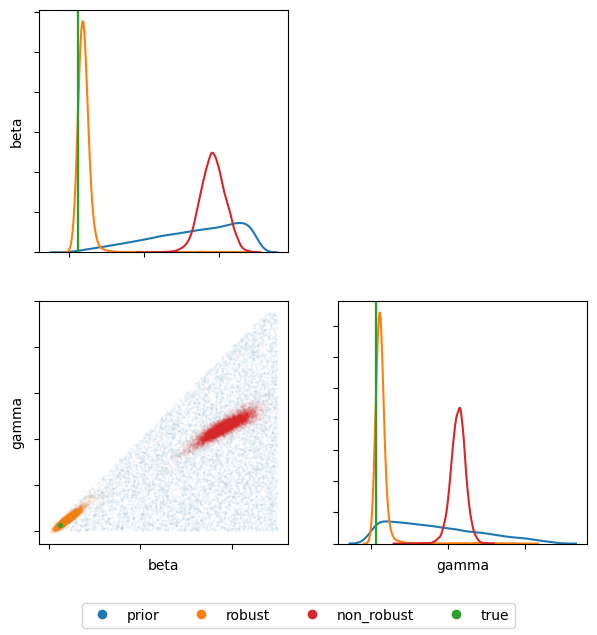

In [21]:
names = list(posteriors.keys())
names.append("true")
pairplot(posteriors.values(), theta_true, col_names = ["beta", "gamma"], names=names)